# Regression

In [30]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

## Regression intro

- What is regression
- Supervised learning

### Linear regression

- Linear model
- Common approaches
  - Least squares
  - Bayesian linear regression

### California housing dataset

The California housing dataset includes

In [28]:
housing_data = fetch_california_housing(as_frame=True)

df = housing_data['frame']
print(df.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


The housing data comprises of 8 features:

- `MedInc`: Median income of the population in the block.
- `HouseAge`: Average age of houses in the block.
- `AveRooms`: Average number of rooms in a house in the block.
- `AveBedrms`: Average number of bedrooms in a house in the block.
- `Population`: Population of the block.
- `AveOccup`: The average number of people living in a house.
- `Latitude`: Latitudinal position.
- `Logitude`: Longitudinal position.
- `MedHouseVal`: The median value of houses in the block.
 
The target feature is `MedHouseVal`.

We shall now look at the datatypes for each feature.

In [29]:
print(df.dtypes)

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object


Each of the features are numerical, as is the target feature which makes regression easier.

### Geographical data

As the data is geographical it is a good idea to visualise it as such.

Using the `Latitude` and `Longitude` features we can plot the data as a scatter plot. Using the `alpha` parameter we can get an idea of population density across California.

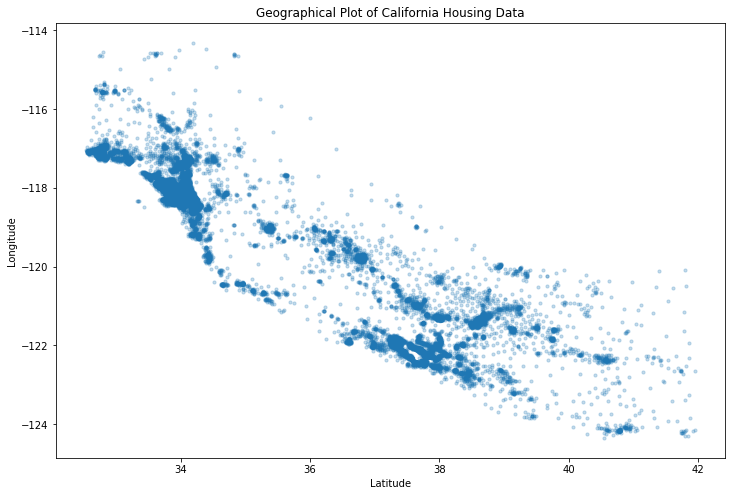

In [83]:
latitude = df['Latitude']
longitude = df['Longitude']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Geographical Plot of California Housing Data")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=10, alpha=0.25)
plt.show()

We can assume the whitespace in the lower left corner is due to no houses being located in the ocean. This means the high density points are along the coast, which may have a high correlation with house price.

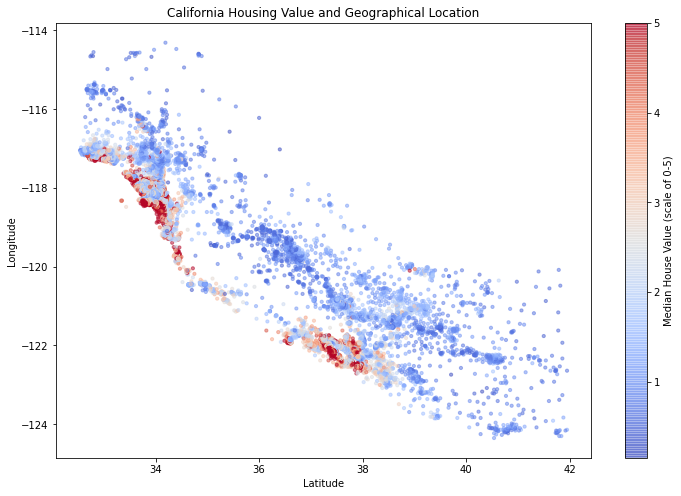

In [84]:
house_val = df['MedHouseVal']

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("California Housing Value and Geographical Location")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(latitude, longitude, s=10, alpha=0.5, c=house_val, cmap='coolwarm')
plt.colorbar().set_label("Median House Value (scale of 0-5)")
plt.show()

From the scatter plot above we can see the more expensive (red) areas are closely packed, with the cheaper (blue) areas being far more scattered, as well as (generally) being further away from the coast. We can assume the more expensive areas relate to Los Angeles (north) and San Fransisco (south). We will need to ensure geographical data is encoded into the model as location evidetely has an impact on house price.

### Correlations

- Look at correlations between features
- PCA?

In [182]:
df.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.540000   -124.350000      0.149990  
25%        2.429741     33.930000   -121.800000      1.196000  
50%        2.818116     34.260000   -118.490000      1.797000  
75%        3.282261     37.710000   -118.010000      2.647250  
max     1243.333333     41.950000   -114.310000      5.000010

In [74]:
non_geo = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

corr = df[non_geo].corr()
print(corr)

              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
MedInc      1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766
HouseAge   -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191
AveRooms    0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852
AveBedrms  -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181
Population  0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863
AveOccup    0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000


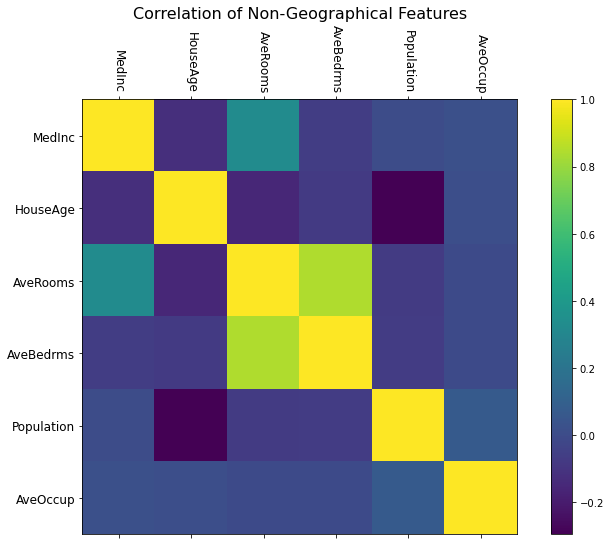

In [160]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Correlation of Non-Geographical Features", fontsize=16)
mat = ax.matshow(corr)
ax.set_xticks(range(len(non_geo)))
ax.set_yticks(range(len(non_geo)))
ax.set_xticklabels(non_geo, rotation=-90, fontsize=12)
ax.set_yticklabels(non_geo, fontsize=12)
plt.colorbar(mat, ax=ax)
plt.show()

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>],
       [<AxesSubplot:title={'center':'AveRooms'}>,
        <AxesSubplot:title={'center':'AveBedrms'}>],
       [<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>]], dtype=object)

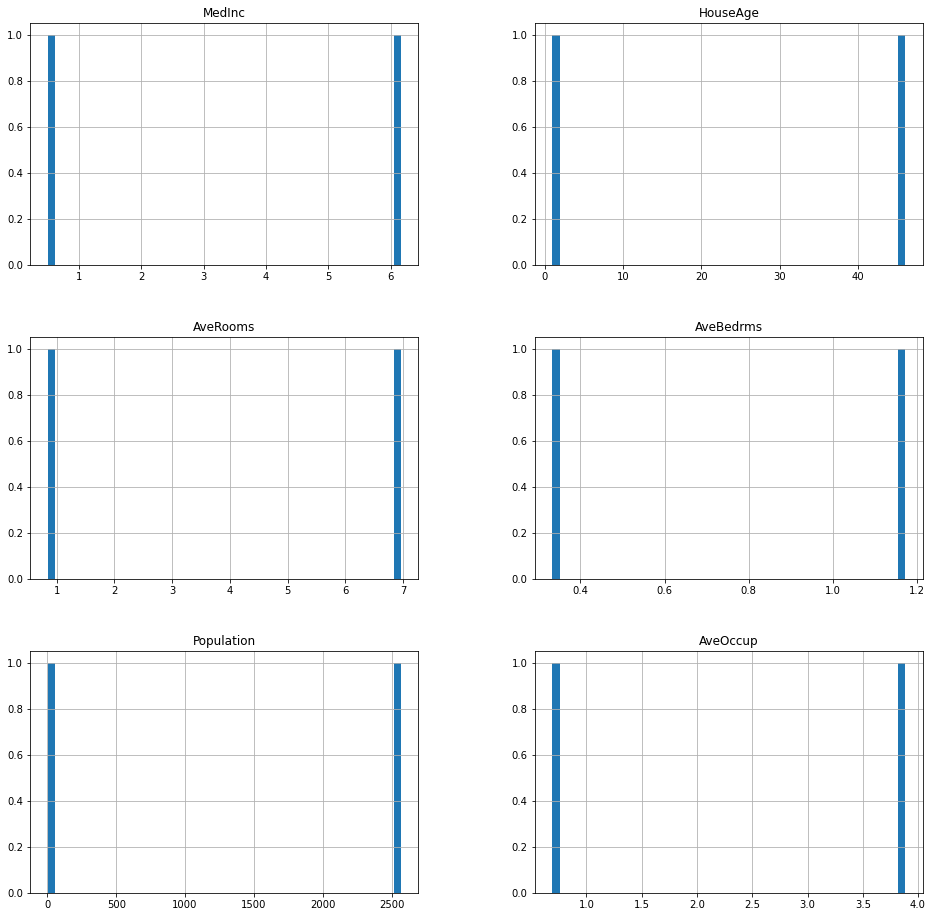

In [193]:
df[non_geo].quantile([0, 0.9]).hist(bins=50, figsize=(16,16))

### Missing data

- Check for missing data
- Handle missing data

### Outliers

- Check for outliers
- Handle / justify outliers

### Feature engineering

- Feature engineering
- Feature selection
- Feature set

### Categorical features

- Handle categorical features
- One-hot encoding?

### Pipeline

- Create pipeline

### Notes on sampling

- In group bias
- Ground truth
- Prior belief
- Sampling bias
- Selection bias
- Bias variance trade-off